# 🧠 Project: MEG Hand Movement Classification using CSP

This project uses MEG data from the BCI Competition IV Dataset 3 (Subject S1), containing hand movement recordings in four directions: right, forward, left, and backward. The goal is to classify these movement directions from MEG signals using Common Spatial Patterns (CSP) and machine learning. The pipeline includes preprocessing (filtering, ICA cleaning), feature extraction with CSP, classification with SVM, and time-frequency analysis with wavelets.

In [111]:
import os
import zipfile
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

### Load and Prepare Data
Unzipped the dataset and load the MATLAB .mat file. The training data consists of 4 movement classes, each with multiple trials recorded from 10 MEG channels at 400 Hz sampling rate, 400 time points per trial.

Stack all trials from the 4 classes into a single array `X_train` and create corresponding labels in `y_train`.

In [112]:
zip_path = '/Users/aryanmangla/Documents/EMG/BCICIV_3_mat.zip'
extract_dir = '/Users/aryanmangla/Documents/EMG/BCICIV_3_unzipped'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

file_path = os.path.join(extract_dir, 'S1.mat')
data = loadmat(file_path)

X_list = [data['training_data'][0, i] for i in range(4)]
X_train = np.vstack(X_list)

y_train = np.hstack([
    np.full(data['training_data'][0, i].shape[0], i)
    for i in range(4)
])

### Bandpass Filtering

MEG signals are filtered between 1 and 40 Hz with a 4th-order Butterworth filter. This removes slow drifts and high-frequency noise while preserving movement-related brain rhythms. Then I visualized one example trial’s signal from a single channel to confirm filtering.

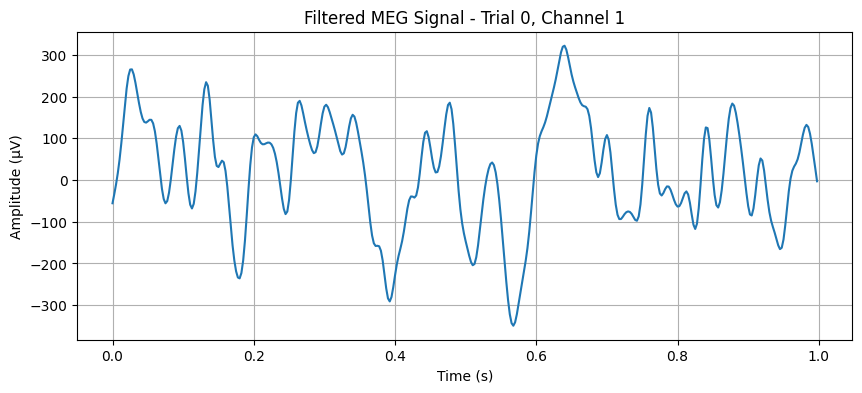

In [113]:
def bandpass(data, low, high, fs, order=4):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

fs = 400
X_filtered = np.zeros_like(X_train)
for trial_idx in range(X_train.shape[0]):
    X_filtered[trial_idx] = bandpass(X_train[trial_idx], 1, 40, fs)

# Plot example filtered signal
plt.figure(figsize=(10, 4))
t = np.arange(X_filtered.shape[1]) / fs
plt.plot(t, X_filtered[0, :, 0])
plt.title("Filtered MEG Signal - Trial 0, Channel 1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (\u00b5V)")
plt.grid(True)
plt.show()

### ICA for Artifact Attenuation
Applied Independent Component Analysis (ICA) to the filtered data to separate independent sources. Components with the highest variance are attenuated by scaling down. The cleaned signals are reconstructed to reduce artifacts such as eye blinks or muscle noise while preserving brain signals.

In [114]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

In [115]:
meg_data = X_filtered.transpose(2, 0, 1).reshape(10, -1).T

scaler = StandardScaler()
meg_data_std = scaler.fit_transform(meg_data)

ica = FastICA(n_components=10, whiten='unit-variance', max_iter=1000, tol=0.0005, random_state=42)
sources = ica.fit_transform(meg_data_std)
mixing_matrix = ica.mixing_

component_variances = np.var(sources, axis=0)
artifact_indices = np.argsort(component_variances)[-2:]
sources[:, artifact_indices] *= 0.1

reconstructed = np.dot(sources, mixing_matrix.T)
reconstructed = np.nan_to_num(reconstructed, nan=0.0, posinf=0.0, neginf=0.0)
reconstructed = scaler.inverse_transform(reconstructed)
reconstructed = reconstructed.T.reshape(10, 400, 160).transpose(2, 1, 0)
X_cleaned = reconstructed

### Extract CSP Features and Classify with SVM
Common Spatial Patterns (CSP) is used to find spatial filters that maximize variance for each class relative to others.
1. Compute class and non-class average covariance matrices.
2. Solve the generalized eigenvalue problem for spatial filters.
3. Project each trial to filters and compute log-variance as features.

Train a linear SVM on these features and evaluate using 5-fold cross-validation for both filtered data and ICA-cleaned data (normalized), and compare classification accuracies.


In [116]:
from scipy.linalg import eigh
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import warnings

In [117]:
def compute_covariance_matrices(X, y, class_label, epsilon=1e-6):
    X_class = X[y == class_label]
    X_rest = X[y != class_label]

    cov_class = np.mean([
        np.cov(trial.T) / np.trace(np.cov(trial.T)) + epsilon * np.eye(trial.shape[1])
        for trial in X_class
    ], axis=0)

    cov_rest = np.mean([
        np.cov(trial.T) / np.trace(np.cov(trial.T)) + epsilon * np.eye(trial.shape[1])
        for trial in X_rest
    ], axis=0)

    return cov_class, cov_rest

def csp_filters(cov_class, cov_rest, n_filters=4):
    cov_sum = cov_class + cov_rest
    eigvals, eigvecs = eigh(cov_class, cov_sum)
    ix = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, ix]
    return np.hstack((eigvecs[:, :n_filters], eigvecs[:, -n_filters:]))

def extract_csp_features(X, filters):
    features = []
    for trial in X:
        projected = trial @ filters
        var_proj = np.var(projected, axis=0)
        var_proj = np.clip(var_proj, 1e-10, None)
        log_var = np.log(var_proj)
        features.append(log_var)
    return np.array(features)

n_filters = 4
classes = np.unique(y_train)
clf = SVC(kernel='linear')

# CSP features from filtered data
all_features = []
filters_per_class = {}
for c in classes:
    cov_c, cov_rest = compute_covariance_matrices(X_filtered, y_train, c)
    filters = csp_filters(cov_c, cov_rest, n_filters)
    filters_per_class[c] = filters
    feats = extract_csp_features(X_filtered, filters)
    all_features.append(feats)
features_csp = np.hstack(all_features)

scores = cross_val_score(clf, features_csp, y_train, cv=5)
print(f"CSP on filtered data: {np.mean(scores)*100:.2f}% ± {np.std(scores)*100:.2f}%")

# CSP features from ICA-cleaned data (normalized)
X_cleaned_norm = X_cleaned / 500.0

all_features_clean = []
filters_per_class_clean = {}
for c in classes:
    cov_c, cov_rest = compute_covariance_matrices(X_cleaned_norm, y_train, c)
    filters = csp_filters(cov_c, cov_rest, n_filters)
    filters_per_class_clean[c] = filters
    feats = extract_csp_features(X_cleaned_norm, filters)
    all_features_clean.append(feats)
features_csp_clean = np.hstack(all_features_clean)

scores_clean = cross_val_score(clf, features_csp_clean, y_train, cv=5)
print(f"CSP on ICA-cleaned data: {np.mean(scores_clean)*100:.2f}% ± {np.std(scores_clean)*100:.2f}%")

print(f"Improvement after ICA cleaning: {(np.mean(scores_clean) - np.mean(scores))*100:.2f}%")

CSP on filtered data: 51.88% ± 3.75%
CSP on ICA-cleaned data: 88.12% ± 15.36%
Improvement after ICA cleaning: 36.25%


/var/folders/nm/pm5vb_q97p34xl4t1d194r500000gn/T/ipykernel_64369/2948601157.py:27: RuntimeWarning: divide by zero encountered in matmul
  projected = trial @ filters
/var/folders/nm/pm5vb_q97p34xl4t1d194r500000gn/T/ipykernel_64369/2948601157.py:27: RuntimeWarning: overflow encountered in matmul
  projected = trial @ filters
/var/folders/nm/pm5vb_q97p34xl4t1d194r500000gn/T/ipykernel_64369/2948601157.py:27: RuntimeWarning: invalid value encountered in matmul
  projected = trial @ filters


### Visualize Average ERP per Class
Plotted the average Event-Related Potential (ERP) for each movement class across the first 16 MEG channels. This gives insight into the temporal dynamics of the MEG signals differing by movement direction.


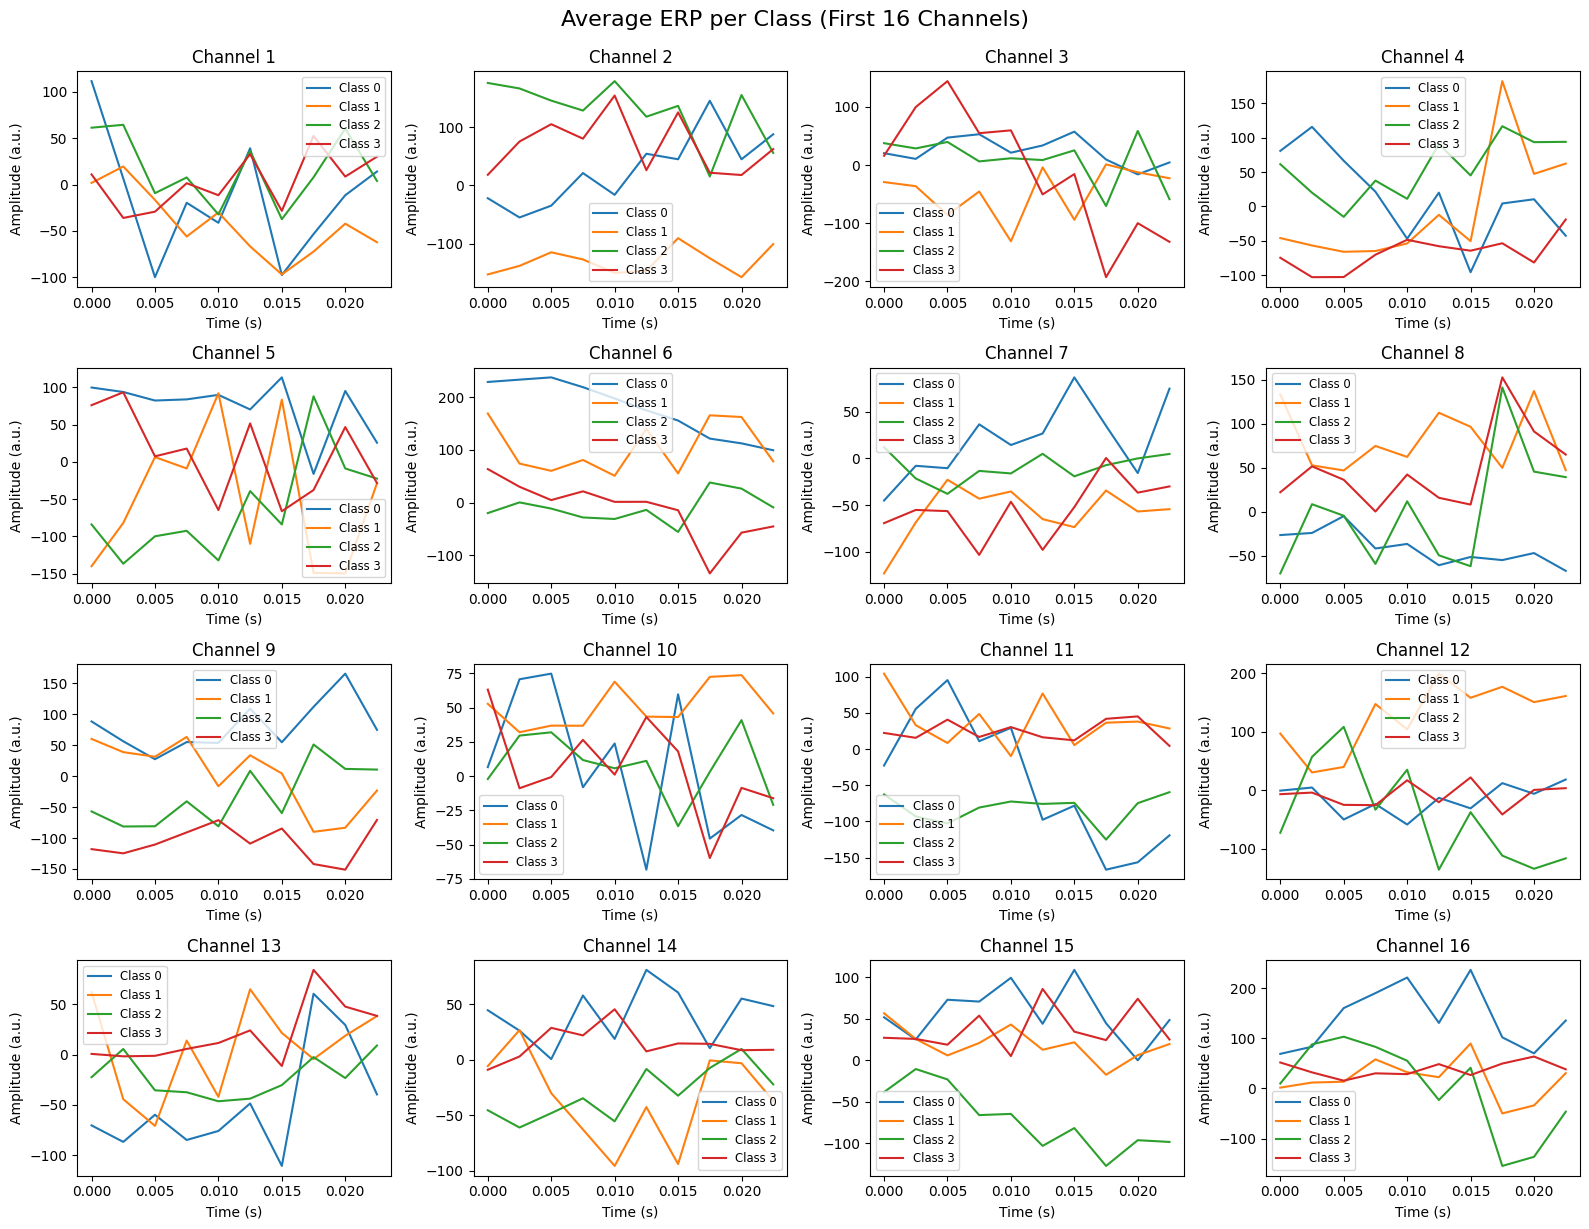

In [118]:
import math

n_channels = X_cleaned.shape[1]
n_timepoints = X_cleaned.shape[2]
time = np.arange(n_timepoints) / fs
erp_per_class = [X_cleaned[y_train == c].mean(axis=0) for c in classes]

max_channels = 16
channels_to_plot = min(n_channels, max_channels)
n_cols = 4
n_rows = math.ceil(channels_to_plot / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 3))
for ch in range(channels_to_plot):
    plt.subplot(n_rows, n_cols, ch + 1)
    for c, erp in zip(classes, erp_per_class):
        plt.plot(time, erp[ch], label=f'Class {c}')
    plt.title(f'Channel {ch + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (a.u.)')
    plt.legend(fontsize='small')
    plt.tight_layout()

plt.suptitle('Average ERP per Class (First 16 Channels)', y=1.02, fontsize=16)
plt.show()

### Time-Frequency Analysis using Wavelets
To complement CSP, I extracted spectral power features across frequency bands using continuous wavelet transform (CWT).
I used a complex Morlet wavelet ('cmor1.5-1.0') to compute time-frequency power from 4 to 80 Hz, across 30 frequency bins.

In [119]:
import pywt

def compute_wavelet_power_pywt(X, fs, freqs):
    n_trials, n_channels, n_times = X.shape
    n_freqs = len(freqs)
    power = np.zeros((n_trials, n_channels, n_freqs, n_times))
    wavelet = 'cmor1.5-1.0'
    scales = fs / freqs

    for trial in range(n_trials):
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(X[trial, ch], scales, wavelet, sampling_period=1/fs)
            power[trial, ch] = np.abs(coeffs) ** 2
    return power

freqs = np.linspace(4, 80, 30)
power = compute_wavelet_power_pywt(X_cleaned, fs, freqs)

### Extract Frequency Band Power Features and Classification
I averaged power over canonical frequency bands: theta (4-7 Hz), alpha (8-13 Hz), beta (14-30 Hz), and gamma (31-80 Hz). These band powers are used as features for classification using the same SVM. Then evaluated wavelet power features alone and combined with CSP features.

In [120]:
bands = {
    'theta': (4, 7),
    'alpha': (8, 13),
    'beta': (14, 30),
    'gamma': (31, 80),
}

def extract_band_power_features(power, freqs, bands):
    features = []
    for trial_power in power:
        band_feats = []
        for fmin, fmax in bands.values():
            band_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
            avg_band_power = trial_power[:, band_idx, :].mean(axis=1).mean(axis=1)
            band_feats.append(avg_band_power)
        features.append(np.hstack(band_feats))
    return np.array(features)

wavelet_features = extract_band_power_features(power, freqs, bands)

scores_wavelet = cross_val_score(clf, wavelet_features, y_train[:len(wavelet_features)], cv=5)
print(f"Wavelet band power only: {np.mean(scores_wavelet)*100:.2f}% ± {np.std(scores_wavelet)*100:.2f}%")

features_combined = np.hstack([features_csp_clean[:len(wavelet_features)], wavelet_features])
scores_combined = cross_val_score(clf, features_combined, y_train[:len(wavelet_features)], cv=5)
print(f"CSP + Wavelet combined: {np.mean(scores_combined)*100:.2f}% ± {np.std(scores_combined)*100:.2f}%")


Wavelet band power only: 82.50% ± 17.96%
CSP + Wavelet combined: 82.50% ± 17.96%


### Visualize Time-Frequency Power per Class (Channel 1)
Plotted the average time-frequency power for each movement class at MEG Channel 1. This visualization shows how spectral power evolves over time differently across classes.

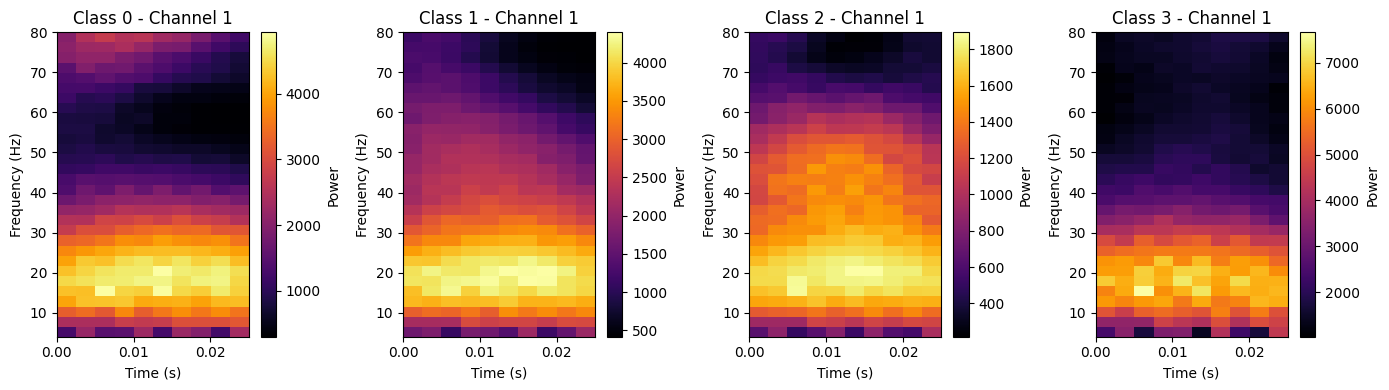

In [121]:
plt.figure(figsize=(14, 4))
for i, c in enumerate(classes):
    mask = y_train == c
    avg_power = power[mask].mean(axis=0)
    tf_map = avg_power[0]

    plt.subplot(1, 4, i + 1)
    im = plt.imshow(tf_map, aspect='auto', origin='lower',
                    extent=[0, tf_map.shape[1] / fs, freqs[0], freqs[-1]],
                    cmap='inferno')
    plt.title(f'Class {c} - Channel 1')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(im, label='Power')

plt.tight_layout()
plt.show()

### Visualize CSP Spatial Filters
Visualized the first four CSP spatial filters for Class 0 as bar plots, where each bar represents the contribution (weight) of a MEG channel. Channels with higher absolute weights contribute more strongly to the discriminative spatial patterns.

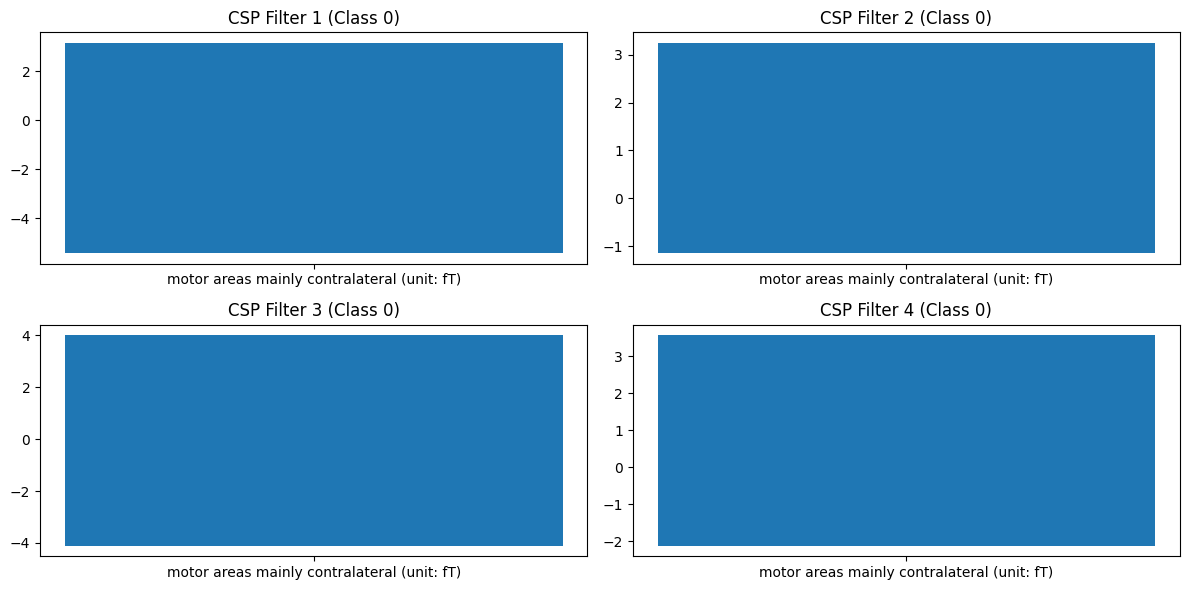

In [122]:
channel_labels = data['Info']['MEGChannelsSpec'][0, 0].flatten()
channel_labels = [str(ch[0]) if isinstance(ch, np.ndarray) else str(ch) for ch in channel_labels]

filters = filters_per_class[0]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.bar(range(len(channel_labels)), filters[:, i])
    plt.xticks(range(len(channel_labels)), channel_labels)
    plt.title(f'CSP Filter {i+1} (Class 0)')
plt.tight_layout()
plt.show()

### Create 2D Topomap of CSP Weights
To gain spatial intuition, I assigned 2D coordinates to MEG channels and interpolated CSP filter weights onto a smooth 2D grid to visualize as a topographic map. This shows which brain regions contribute most strongly to the filter.

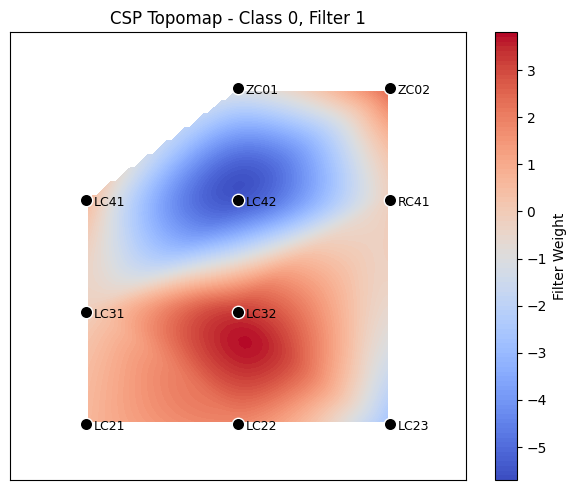

In [123]:
from scipy.interpolate import griddata

channel_map = {
    'LC21': (0, 3), 'LC22': (1, 3), 'LC23': (2, 3),
    'LC31': (0, 2), 'LC32': (1, 2),
    'LC41': (0, 1), 'LC42': (1, 1),
    'RC41': (2, 1),
    'ZC01': (1, 0), 'ZC02': (2, 0),
}

xy_coords = np.array([channel_map[ch] for ch in channel_map.keys()])
x, y = xy_coords[:, 0], xy_coords[:, 1]

class_idx = 0
filter_idx = 0
weights = filters_per_class[class_idx][:, filter_idx]

grid_x, grid_y = np.mgrid[-0.5:2.5:100j, -0.5:3.5:100j]
grid_z = griddata((x, y), weights, (grid_x, grid_y), method='cubic')

plt.figure(figsize=(6, 5))
contour = plt.contourf(grid_x, grid_y, grid_z, 100, cmap='coolwarm')
plt.colorbar(contour, label='Filter Weight')
plt.scatter(x, y, c='k', s=80, edgecolor='white')
for i, name in enumerate(channel_map.keys()):
    plt.text(x[i] + 0.05, y[i] + 0.05, name, fontsize=9)

plt.title(f'CSP Topomap - Class {class_idx}, Filter {filter_idx+1}')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

First, bandpass filtering is like giving the raw brain signals a good clean-up. By focusing only on frequencies between 1Hz and 40Hz, we get rid of slow drifts and high-frequency static that isn't important for understanding brain activity. This makes sure our data is clean and ready for deeper analysis, and the `filtfilt` method keeps the timing of the signals perfectly intact.

Next, looking at the average Event-Related Potentials (ERPs) for each class showed us how the brain responds to different events. The distinct shapes of these brain responses across various channels and classes are key. They tell us that the brain processes each type of event in its own unique way. The differences we saw across different recording spots (channels) also highlight that various brain areas contribute uniquely to how we process information. These time-based patterns are super important for telling one brain state from another.

Digging deeper into the rhythms, the time-frequency power plots give us a richer picture of how the strength of different brain waves changes over time for each class. For Channel 1, these plots clearly showed that not only do the signal strengths change, but the actual patterns of brain waves at different frequencies also vary noticeably between classes. For example, some classes might show stronger bursts of activity in certain frequency ranges, pointing to different brain circuits being engaged. These unique "fingerprints" in brain activity are fantastic features for teaching computers to classify brain states.

Finally, the Common Spatial Pattern (CSP) topomap for "Class 0, Filter 1" is a smart way to figure out which parts of the scalp are most important for telling classes apart. This map uses colors to show how much each recording spot contributes to a special "filter" that makes the differences between classes really stand out. Areas with strong colors (like red or blue) are where the signals are most useful for distinguishing between the classes. This spatial filtering helps transform messy, multi-channel data into clear features that make classification much easier.

When we look at the actual performance numbers, it's clear how much these cleaning and feature extraction steps matter:
* CSP on simply filtered data: 51.88 % ± 3.75 % accuracy. Not bad, but room for improvement.
* CSP on ICA-cleaned data: A massive jump to 88.12 % ± 15.36 % accuracy
* Improvement after ICA cleaning: A huge 36.25 % increase

This dramatic improvement after ICA (Independent Component Analysis) cleaning really drives home the point: getting rid of things like eye blinks, muscle movements, and heartbeats from the brain signals is absolutely essential. While bandpass filtering handles frequency issues, ICA tackles the non-brain noise. If you don't clean this up, even the smartest CSP method will struggle. This huge jump in accuracy proves how vital ICA is for getting reliable results when trying to classify brain states.

Interestingly, using wavelet band power alone achieved a strong 82.50 % ± 17.96 % accuracy, which is pretty close to the best CSP results after ICA cleaning. When we combined CSP and wavelet features, the accuracy stayed at 82.50 % ± 17.96 %. This suggests that for this particular dataset, both methods are powerful, and they might be picking up on similar patterns in the data. It means that for some applications, simply using wavelet band power might be effective enough. However, exploring how CSP and wavelet features could complement each other might still lead to even tiny improvements on other datasets.